In [81]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     -------------------------------------- 288.2/288.2 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 7.2/7.2 MB 25.6 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 52.2 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB ? eta 0:00:00
     ------------------------------------- 965.4/965.4 kB 59.7 MB/s eta 0:00:00
     ---------------------------------------- 163.6/163.6 kB ? eta 0:00:00
     ---------------------------------------- 55.3/55.3 kB ? eta 0:00:00


In [1]:
api_service_name = "coingecko"

In [2]:
import json, hmac, hashlib, time, requests, json, datetime
import pandas as pd
from datetime import date
from IPython.display import JSON
import seaborn as sbs

In [85]:
# Get API request
def api_coins_list():
    api_url = 'https://api.coingecko.com/api/v3/coins/list?include_platform=true'
    all_data = []
    r = requests.get(api_url)
    #print(r.json())
    # JSON(r.json()[0])
    #for item in r['items']:
    # Write to file -- debug
    #f = open("temp_file.txt", "w+")
    with open("coin_ids.txt", "w") as f:
        json.dump(r.json(), f)


In [34]:
test_function()

In [86]:
def load_file():
    f = open("coin_ids.txt", "r", encoding="utf8")    
    return f.read()

In [68]:
JSON(json.loads(load_file()))

<IPython.core.display.JSON object>

In [100]:
def get_data():
    json_data = load_file()
    currencies = json.loads(json_data)
    all_data = []
    # id, symbol, name, platform
    for item in currencies:
        data = {
            'id': item['id'],
            'name': item['name']
        }
        all_data.append(data)
    df = pd.DataFrame(all_data)
    df.to_csv('coin_data.txt', header=True, index=None, mode='w')
    

In [101]:
get_data()

## Prompts

##### Compared to a certain coin, should the user trade user's current coin by looking at historical trend

In [114]:
def get_coin_market_chart(coin_id):
    """
        Params: str - coin_id
        Return: bool - valid return value, list [str, str] - coin market chart [timestamp in ms, price]
    """
    coin_ids_df = pd.read_csv("coin_data.txt")
    
    #if coin_id not in coin_ids_df['id']:
    if not coin_ids_df['id'].eq(coin_id).any():        
        return [None, None]
    coin_name = coin_ids_df.loc[coin_ids_df['id'] == coin_id].values[0][1]
    
    
    # timestamp at 12 AM
    today = date.today()
    timestamp = time.mktime(today.timetuple())
    
    # market in the past 7 days
    day_in_seconds = 86400     
    timestamp -= day_in_seconds * 7
    
    request_url = 'https://api.coingecko.com/api/v3/coins/{coin}/market_chart?vs_currency=usd&days=14&interval=daily'.format(coin=coin_id)
    # the last index is the current time. [:-2] 12 AM of current date.
    r = requests.get(request_url)        
    
    return [coin_name, r.json()["prices"]]

In [106]:
def week_timestamps():
    """
        Return: list 
                    - 0, 1 this week's mon to current day timestamp
                    - 2, 3 last week time stamps mon to fri
    """
    from datetime import date, datetime, timedelta

    today = date.today()                
    day_in_seconds = 86400     
    timestamp_today = time.mktime(today.timetuple())
    timestamp_start = timestamp_today - day_in_seconds * today.weekday()
    
    # last week
    timestamp_last_start = timestamp_start - day_in_seconds * 7
    timestamp_last_end = timestamp_start - day_in_seconds * 3    
    
    return [int(timestamp_start), int(timestamp_today),\
           int(timestamp_last_start), int(timestamp_last_end)]

In [210]:
week_timestamps()

[1670821200, 1671166800, 1670216400, 1670562000]

In [35]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\belmo\Documents\AngeloProjects\currency-exchange-rate\project_env\Scripts\python.exe
3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


In [108]:
def day_choice(day):
    match day:
        case 0:
            return 'Mon'
        case 1:
            return 'Tue'
        case 2:
            return 'Wed'
        case 3:
            return 'Thu'
        case 4:
            return 'Fri'
        case _:
            return 'None'                

def get_prices(bitcoin_id):
    coin_chart = get_coin_market_chart(bitcoin_id)
    timestamps = week_timestamps()   
    if coin_chart[0] is None:
        return None
            
    # get items
    last_week_data, this_week_data = [], []    
    day_counter_last, day_counter_this = 0, 0
    for item in coin_chart[1]:
        timestamp = int(item[0] // 1000)
        # print("%s < %s < %s" % (timestamps[0], timestamp, timestamps[1]))
        
        if timestamps[0] <= timestamp <= timestamps[1]:
            #this_week_data.append(item)
            data = {
                'date': datetime.date.fromtimestamp(timestamp),
                'day': day_choice(day_counter_last),
                'price': item[1],
                'week': 'last'
            }
            day_counter_last += 1
            this_week_data.append(data)            
        elif timestamps[2] <= timestamp <= timestamps[3]:
            #last_week_data.append(item)        
            data = {
                'date': datetime.date.fromtimestamp(timestamp),
                'day': day_choice(day_counter_this),
                'price': item[1],
                'week': 'this'
            }
            day_counter_this += 1
            last_week_data.append(data)

    last_week_df = pd.DataFrame(last_week_data)
    this_week_df = pd.DataFrame(this_week_data)
    
    return [coin_chart[0], this_week_df, last_week_df]    

In [47]:
get_prices()

[         date   day         price  week
 0  2022-12-12   Mon  17179.596038  last
 1  2022-12-13   Tue  17784.162894  last
 2  2022-12-14   Wed  17808.716173  last
 3  2022-12-15   Thu  17338.358127  last
 4  2022-12-16   Fri  16623.757826  last
 5  2022-12-17  None  16806.485592  last,
          date  day         price  week
 0  2022-12-05  Mon  16973.372578  this
 1  2022-12-06  Tue  17085.643141  this
 2  2022-12-07  Wed  16851.303469  this
 3  2022-12-08  Thu  17235.014158  this]

### Data Analysis



In [121]:
import matplotlib.pylab as plt
def plot_crypto_data(bitcoin_id):
    market_prices = get_prices(bitcoin_id)
    if market_prices[0] is None:
        print("Invalid coin id")
        return
    coin_name, this_week_df, last_week_df = market_prices[0], market_prices[1], market_prices[2]    
    #plt = sbs.barplot(x = 'date', y = 'price', data = last_week_df)
    combined_df = pd.concat([this_week_df, last_week_df], ignore_index=True)
    plot = sbs.relplot(
        data=combined_df, kind="line", 
        hue='week', palette=['lightgrey', 'blue'],
        x="day", y="price", legend='auto',         
    ).set(title='%s Price: Current vs Last Week' % (coin_name))    
    
    plt.xticks(rotation=45)

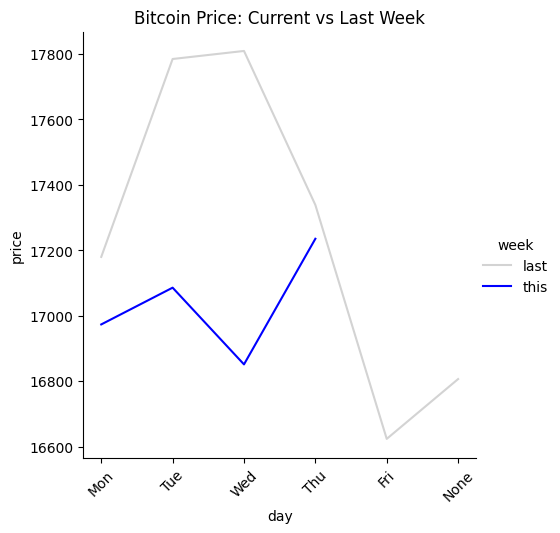

In [123]:
plot_crypto_data('bitcoin')